In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

print("All libraries imported successfully.")

All libraries imported successfully.


In [33]:
# Define paths
data_dir = "../data/splits"
train_path = os.path.join(data_dir, "train.csv")
val_path = os.path.join(data_dir, "validation.csv")
test_path = os.path.join(data_dir, "test.csv")

# Load datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

print(f"Train set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Train set: (3469, 40)
Validation set: (743, 40)
Test set: (744, 40)


In [34]:
# Target column
target_col = 'price'

# Features: all columns except target
feature_cols = [col for col in train_df.columns if col != target_col]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print("Features and target separated.")
print(f"Number of features: {len(feature_cols)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Features and target separated.
Number of features: 39
Training samples: 3469
Validation samples: 743
Test samples: 744


In [35]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """Calculate metrics on train, validation, and test sets."""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Store in dictionary
    metrics = {
        'Model': model_name,
        'Train RMSE': train_rmse,
        'Validation RMSE': val_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Validation MAE': val_mae,
        'Test MAE': test_mae,
        'Train R2': train_r2,
        'Validation R2': val_r2,
        'Test R2': test_r2
    }

    # Print
    print(f"\n{'='*50}")
    print(f"{model_name} Performance:")
    print(f"{'='*50}")
    print(f"  Train RMSE: {train_rmse:.4f} | Validation RMSE: {val_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE : {train_mae:.4f} | Validation MAE : {val_mae:.4f} | Test MAE : {test_mae:.4f}")
    print(f"  Train R2  : {train_r2:.4f} | Validation R2  : {val_r2:.4f} | Test R2  : {test_r2:.4f}")

    # Overfitting indicator
    overfit_gap = val_rmse - train_rmse
    test_gap = test_rmse - train_rmse
    print(f"  Overfit Gap (Val-Train): {overfit_gap:.4f}")
    print(f"  Test Gap (Test-Train): {test_gap:.4f}")

    return metrics, y_train_pred, y_val_pred, y_test_pred

In [36]:
# XGBoost with regularization
xgb_reg_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    max_depth=4,              # Reduced depth
    learning_rate=0.05,        # Lower learning rate
    subsample=0.8,             # Use 80% of data per tree
    colsample_bytree=0.8,      # Use 80% of features per tree
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.0,            # L2 regularization
    min_child_weight=3,        # Minimum sum of instance weight
    gamma=0.1                   # Minimum loss reduction for split
)

# Train
xgb_reg_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

# Evaluate
xgb_reg_metrics, xgb_reg_train_pred, xgb_reg_val_pred, xgb_reg_test_pred = evaluate_model(
    xgb_reg_model, X_train, y_train, X_val, y_val, X_test, y_test, "XGBoost (Regularized)"
)

models = {'XGBoost (Regularized)': xgb_reg_model}


XGBoost (Regularized) Performance:
  Train RMSE: 51.7757 | Validation RMSE: 54.4754 | Test RMSE: 52.9407
  Train MAE : 32.5685 | Validation MAE : 34.6961 | Test MAE : 34.7740
  Train R2  : 0.7682 | Validation R2  : 0.7005 | Test R2  : 0.6985
  Overfit Gap (Val-Train): 2.6997
  Test Gap (Test-Train): 1.1651


In [37]:
# LightGBM with regularization
lgb_reg_model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=100,
    max_depth=5,                # Limit tree depth
    learning_rate=0.05,          # Lower learning rate
    subsample=0.8,               # Bagging fraction
    subsample_freq=1,            # Frequency for bagging
    colsample_bytree=0.8,        # Feature fraction
    reg_alpha=0.1,               # L1 regularization
    reg_lambda=0.1,              # L2 regularization
    min_child_samples=20,        # Minimum data in leaf
    min_split_gain=0.1,          # Minimum gain to split
    verbosity=-1
)

# Train - LightGBM automatically stores evals_result_
lgb_reg_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse'
)

# Evaluate
lgb_reg_metrics, lgb_reg_train_pred, lgb_reg_val_pred, lgb_reg_test_pred = evaluate_model(
    lgb_reg_model, X_train, y_train, X_val, y_val, X_test, y_test, "LightGBM (Regularized)"
)

models['LightGBM (Regularized)'] = lgb_reg_model


LightGBM (Regularized) Performance:
  Train RMSE: 48.0226 | Validation RMSE: 51.6740 | Test RMSE: 49.9125
  Train MAE : 29.0946 | Validation MAE : 33.2273 | Test MAE : 33.3366
  Train R2  : 0.8006 | Validation R2  : 0.7305 | Test R2  : 0.7320
  Overfit Gap (Val-Train): 3.6514
  Test Gap (Test-Train): 1.8900


In [38]:
# CatBoost with regularization
cb_reg_model = cb.CatBoostRegressor(
    random_seed=42,
    iterations=100,
    learning_rate=0.05,           # Lower learning rate
    depth=4,                       # Limit tree depth
    l2_leaf_reg=3.0,               # L2 regularization
    bagging_temperature=0.5,        # Bayesian bagging
    border_count=128,               # Number of splits
    verbose=False
)

# Train
cb_reg_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val)
)

# Evaluate
cb_reg_metrics, cb_reg_train_pred, cb_reg_val_pred, cb_reg_test_pred = evaluate_model(
    cb_reg_model, X_train, y_train, X_val, y_val, X_test, y_test, "CatBoost (Regularized)"
)

models['CatBoost (Regularized)'] = cb_reg_model


CatBoost (Regularized) Performance:
  Train RMSE: 65.6931 | Validation RMSE: 59.8416 | Test RMSE: 55.9711
  Train MAE : 40.3666 | Validation MAE : 39.3006 | Test MAE : 38.8999
  Train R2  : 0.6268 | Validation R2  : 0.6386 | Test R2  : 0.6630
  Overfit Gap (Val-Train): -5.8516
  Test Gap (Test-Train): -9.7220



MODEL COMPARISON SUMMARY

Validation Set Performance:
                        Validation RMSE  Validation MAE  Validation R2
Model                                                                 
XGBoost (Regularized)           54.4754         34.6961         0.7005
LightGBM (Regularized)          51.6740         33.2273         0.7305
CatBoost (Regularized)          59.8416         39.3006         0.6386

Test Set Performance:
                        Test RMSE  Test MAE  Test R2
Model                                               
XGBoost (Regularized)     52.9407   34.7740   0.6985
LightGBM (Regularized)    49.9125   33.3366   0.7320
CatBoost (Regularized)    55.9711   38.8999   0.6630

🏆 Best Model: LightGBM (Regularized) with Test RMSE = 49.9125


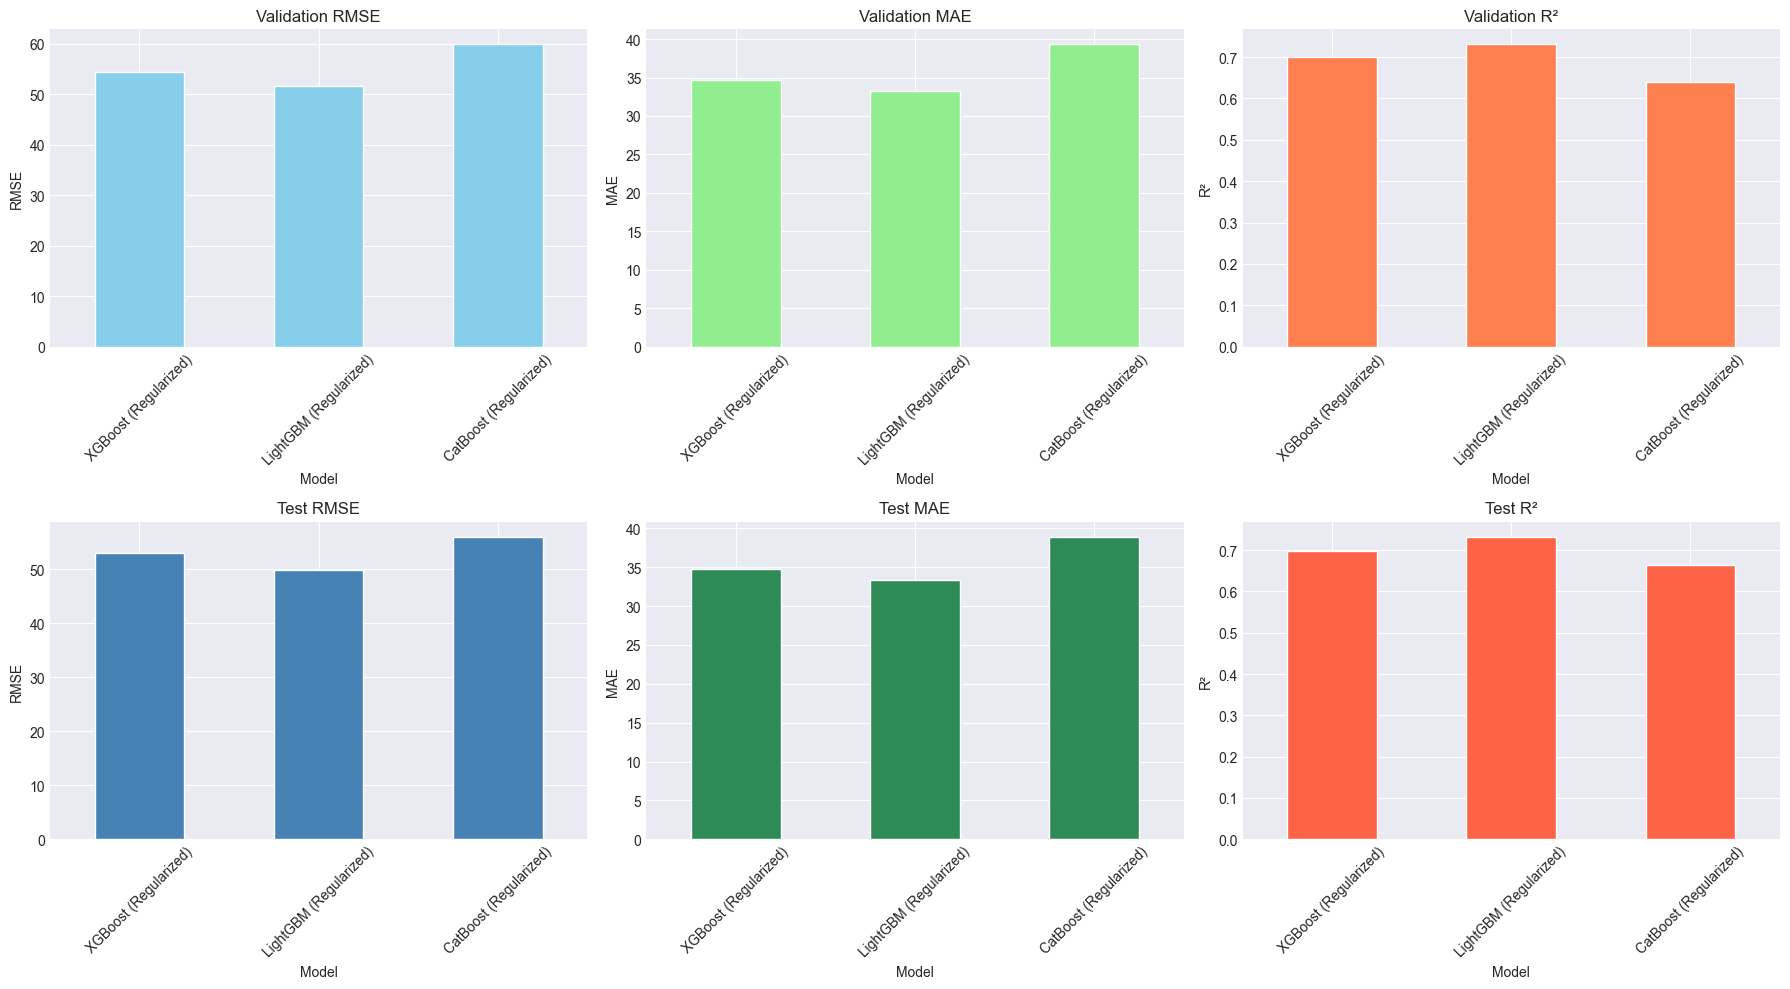

In [39]:
# Combine all metrics into a DataFrame
metrics_list = [xgb_reg_metrics, lgb_reg_metrics, cb_reg_metrics]
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Model', inplace=True)

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print("\nValidation Set Performance:")
print(metrics_df[['Validation RMSE', 'Validation MAE', 'Validation R2']].round(4))

print("\nTest Set Performance:")
print(metrics_df[['Test RMSE', 'Test MAE', 'Test R2']].round(4))

# Find best model based on test RMSE
best_model = metrics_df['Test RMSE'].idxmin()
best_rmse = metrics_df.loc[best_model, 'Test RMSE']
print(f"\n🏆 Best Model: {best_model} with Test RMSE = {best_rmse:.4f}")

# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Validation metrics
metrics_df[['Validation RMSE']].plot(kind='bar', ax=axes[0,0], legend=False, color='skyblue')
axes[0,0].set_title('Validation RMSE')
axes[0,0].set_ylabel('RMSE')
axes[0,0].tick_params(axis='x', rotation=45)

metrics_df[['Validation MAE']].plot(kind='bar', ax=axes[0,1], legend=False, color='lightgreen')
axes[0,1].set_title('Validation MAE')
axes[0,1].set_ylabel('MAE')
axes[0,1].tick_params(axis='x', rotation=45)

metrics_df[['Validation R2']].plot(kind='bar', ax=axes[0,2], legend=False, color='coral')
axes[0,2].set_title('Validation R²')
axes[0,2].set_ylabel('R²')
axes[0,2].tick_params(axis='x', rotation=45)

# Test metrics
metrics_df[['Test RMSE']].plot(kind='bar', ax=axes[1,0], legend=False, color='steelblue')
axes[1,0].set_title('Test RMSE')
axes[1,0].set_ylabel('RMSE')
axes[1,0].tick_params(axis='x', rotation=45)

metrics_df[['Test MAE']].plot(kind='bar', ax=axes[1,1], legend=False, color='seagreen')
axes[1,1].set_title('Test MAE')
axes[1,1].set_ylabel('MAE')
axes[1,1].tick_params(axis='x', rotation=45)

metrics_df[['Test R2']].plot(kind='bar', ax=axes[1,2], legend=False, color='tomato')
axes[1,2].set_title('Test R²')
axes[1,2].set_ylabel('R²')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

LightGBM evals_result_ keys: dict_keys(['training', 'valid_1'])
Using validation key: valid_1
CatBoost evals_result keys: dict_keys(['learn', 'validation'])


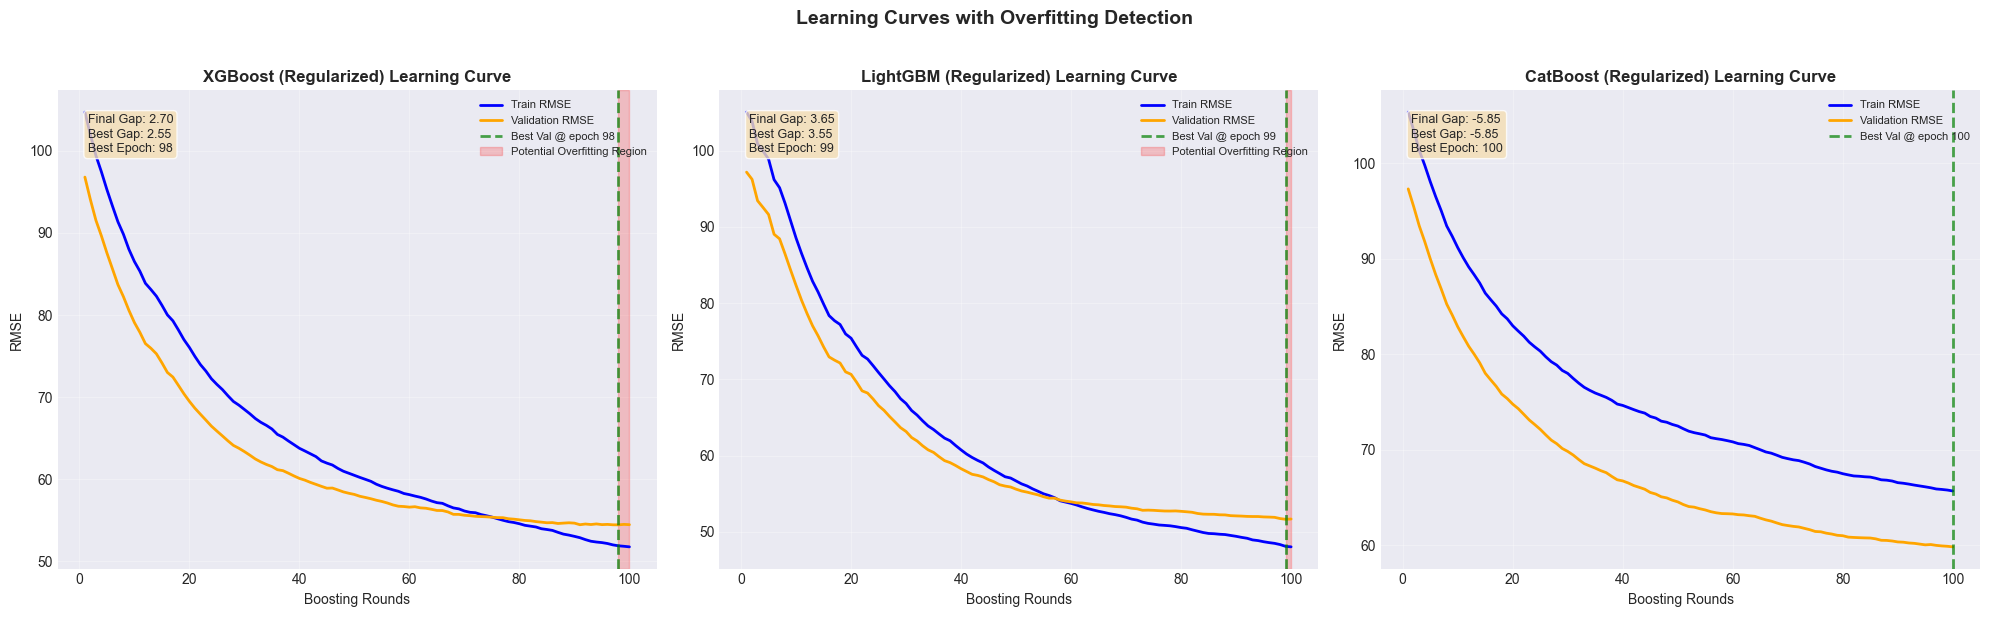


📊 Overfitting Analysis Summary:
      Model  Train RMSE (final)  Val RMSE (final)  Val-Train Gap  Best Epoch  \
0   XGBoost             51.7757           54.4754         2.6997          98   
1  LightGBM             48.0226           51.6740         3.6514          99   
2  CatBoost             65.6931           59.8416        -5.8516         100   

   Best Val RMSE  
0        54.4547  
1        51.6397  
2        59.8416  


In [40]:
# Extract evaluation history from each model

# XGBoost
xgb_results = xgb_reg_model.evals_result()
xgb_train_rmse = xgb_results['validation_0']['rmse']
xgb_val_rmse = xgb_results['validation_1']['rmse']

# LightGBM
lgb_results = lgb_reg_model.evals_result_
print("LightGBM evals_result_ keys:", lgb_results.keys())
# Dynamically find the validation key
lgb_train_key = 'training'
lgb_val_key = None
for key in lgb_results.keys():
    if key != lgb_train_key:
        lgb_val_key = key
        break
if lgb_val_key is None:
    raise ValueError("Could not find validation key in LightGBM evals_result_")
print(f"Using validation key: {lgb_val_key}")
lgb_train_rmse = lgb_results[lgb_train_key]['rmse']
lgb_val_rmse = lgb_results[lgb_val_key]['rmse']

# CatBoost
cb_results = cb_reg_model.get_evals_result()
print("CatBoost evals_result keys:", cb_results.keys())
cb_train_rmse = cb_results['learn']['RMSE']
cb_val_rmse = cb_results['validation']['RMSE']

# Function to plot learning curve with overfitting indicators
def plot_learning_curve_with_overfitting(ax, train_errors, val_errors, model_name):
    epochs = range(1, len(train_errors)+1)
    ax.plot(epochs, train_errors, label='Train RMSE', color='blue', linewidth=2)
    ax.plot(epochs, val_errors, label='Validation RMSE', color='orange', linewidth=2)

    # Find the point where validation error is minimum (best iteration)
    best_epoch = np.argmin(val_errors) + 1
    best_val = val_errors[best_epoch-1]
    ax.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, linewidth=2,
               label=f'Best Val @ epoch {best_epoch}')

    # Shade the region after best epoch if validation error increases (overfitting)
    if best_epoch < len(val_errors):
        ax.axvspan(best_epoch, len(val_errors), alpha=0.2, color='red', label='Potential Overfitting Region')

    # Compute final gap
    final_gap = val_errors[-1] - train_errors[-1]
    early_gap = val_errors[best_epoch-1] - train_errors[best_epoch-1]

    # Add text box with metrics
    textstr = f'Final Gap: {final_gap:.2f}\nBest Gap: {early_gap:.2f}\nBest Epoch: {best_epoch}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)

    ax.set_title(f'{model_name} Learning Curve', fontsize=12, fontweight='bold')
    ax.set_xlabel('Boosting Rounds')
    ax.set_ylabel('RMSE')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

plot_learning_curve_with_overfitting(axes[0], xgb_train_rmse, xgb_val_rmse, 'XGBoost (Regularized)')
plot_learning_curve_with_overfitting(axes[1], lgb_train_rmse, lgb_val_rmse, 'LightGBM (Regularized)')
plot_learning_curve_with_overfitting(axes[2], cb_train_rmse, cb_val_rmse, 'CatBoost (Regularized)')

plt.suptitle('Learning Curves with Overfitting Detection', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Overfitting summary table
overfit_summary = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost'],
    'Train RMSE (final)': [xgb_train_rmse[-1], lgb_train_rmse[-1], cb_train_rmse[-1]],
    'Val RMSE (final)': [xgb_val_rmse[-1], lgb_val_rmse[-1], cb_val_rmse[-1]],
    'Val-Train Gap': [xgb_val_rmse[-1] - xgb_train_rmse[-1],
                      lgb_val_rmse[-1] - lgb_train_rmse[-1],
                      cb_val_rmse[-1] - cb_train_rmse[-1]],
    'Best Epoch': [np.argmin(xgb_val_rmse)+1, np.argmin(lgb_val_rmse)+1, np.argmin(cb_val_rmse)+1],
    'Best Val RMSE': [min(xgb_val_rmse), min(lgb_val_rmse), min(cb_val_rmse)]
})

print("\n📊 Overfitting Analysis Summary:")
print(overfit_summary.round(4))

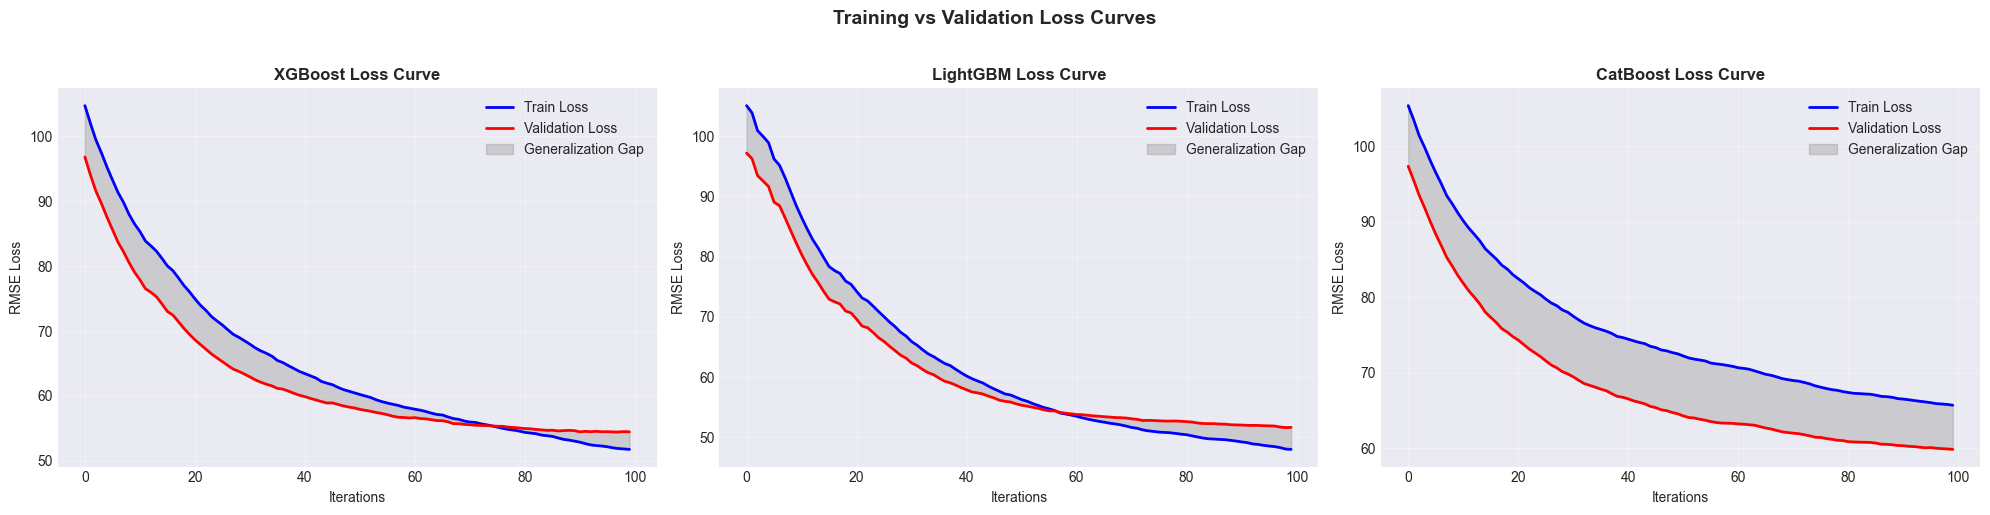

In [41]:
# Plot loss curves for each model
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# XGBoost Loss Curve
axes[0].plot(xgb_train_rmse, label='Train Loss', color='blue', linewidth=2)
axes[0].plot(xgb_val_rmse, label='Validation Loss', color='red', linewidth=2)
axes[0].fill_between(range(len(xgb_train_rmse)), xgb_train_rmse, xgb_val_rmse,
                      alpha=0.3, color='gray', label='Generalization Gap')
axes[0].set_title('XGBoost Loss Curve', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('RMSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LightGBM Loss Curve
axes[1].plot(lgb_train_rmse, label='Train Loss', color='blue', linewidth=2)
axes[1].plot(lgb_val_rmse, label='Validation Loss', color='red', linewidth=2)
axes[1].fill_between(range(len(lgb_train_rmse)), lgb_train_rmse, lgb_val_rmse,
                      alpha=0.3, color='gray', label='Generalization Gap')
axes[1].set_title('LightGBM Loss Curve', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('RMSE Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# CatBoost Loss Curve
axes[2].plot(cb_train_rmse, label='Train Loss', color='blue', linewidth=2)
axes[2].plot(cb_val_rmse, label='Validation Loss', color='red', linewidth=2)
axes[2].fill_between(range(len(cb_train_rmse)), cb_train_rmse, cb_val_rmse,
                      alpha=0.3, color='gray', label='Generalization Gap')
axes[2].set_title('CatBoost Loss Curve', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('RMSE Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Training vs Validation Loss Curves', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

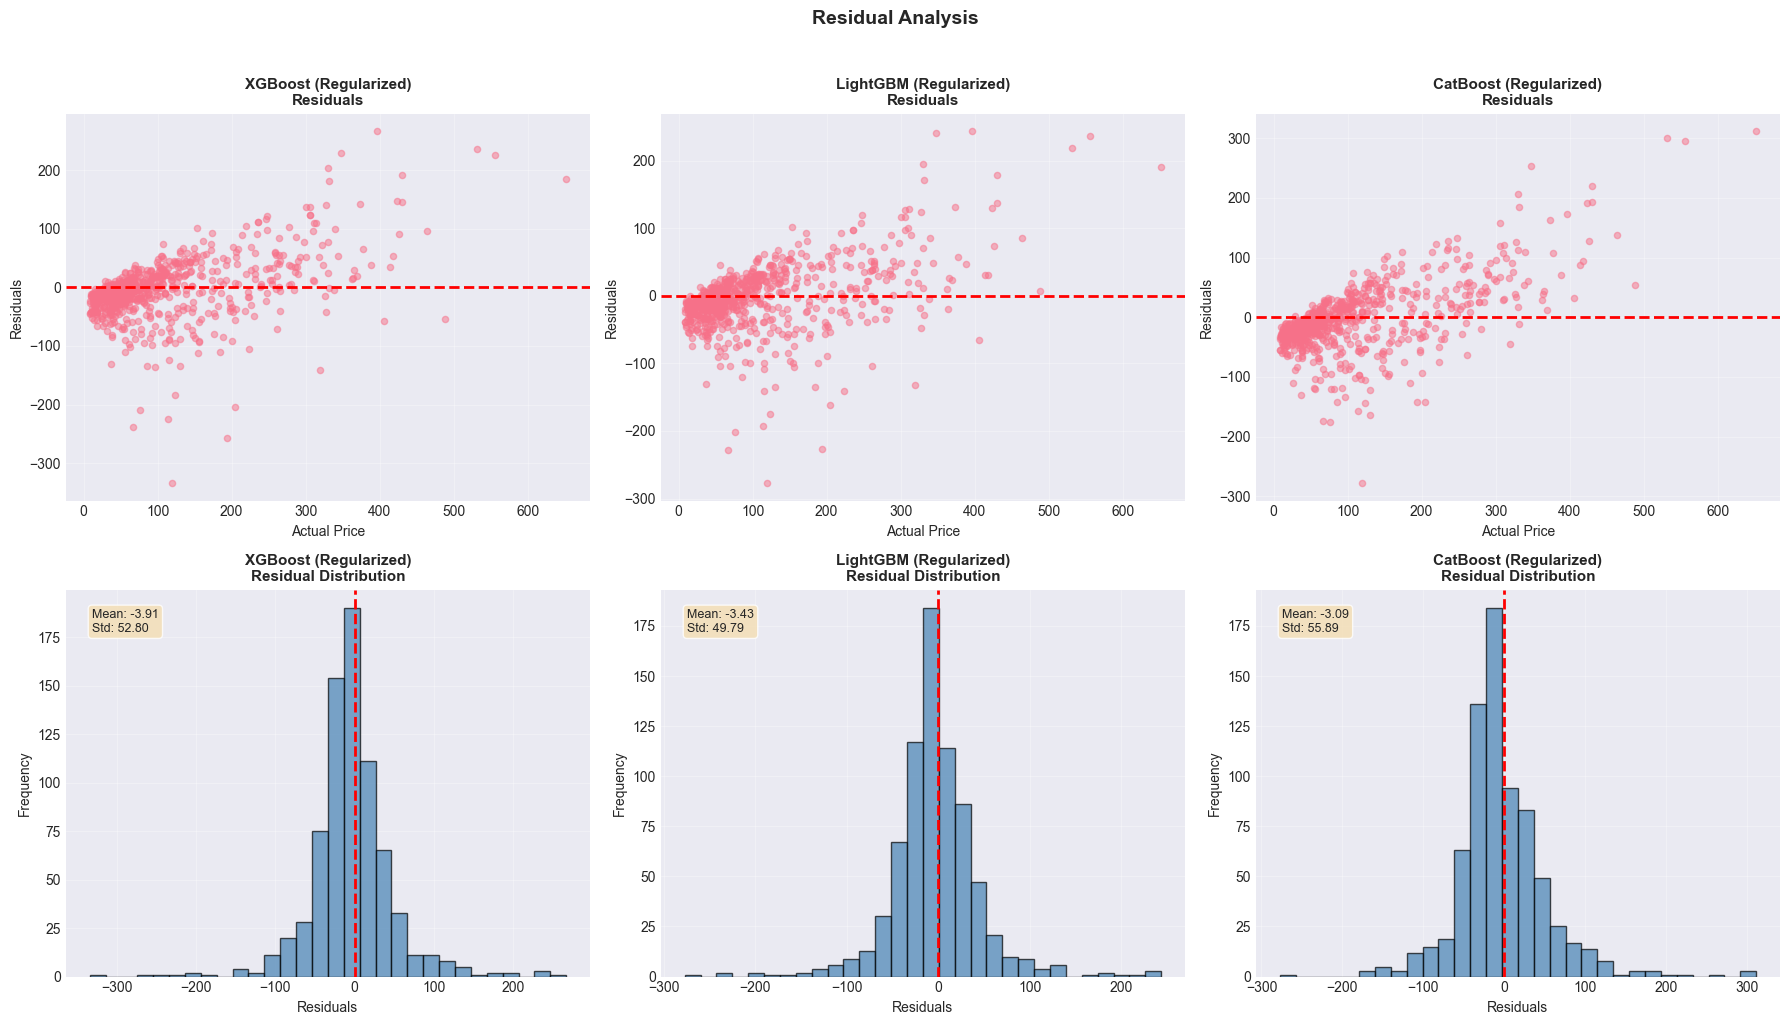

In [42]:
# Create residuals for each model
residuals = {
    'XGBoost (Regularized)': y_test - xgb_reg_test_pred,
    'LightGBM (Regularized)': y_test - lgb_reg_test_pred,
    'CatBoost (Regularized)': y_test - cb_reg_test_pred
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, (name, resid) in enumerate(residuals.items()):
    # Residual scatter plot
    ax = axes[0, i]
    ax.scatter(y_test, resid, alpha=0.5, s=20)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax.set_title(f'{name}\nResiduals', fontsize=11, fontweight='bold')
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Residuals')
    ax.grid(True, alpha=0.3)

    # Residual distribution histogram
    ax = axes[1, i]
    ax.hist(resid, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.set_title(f'{name}\nResidual Distribution', fontsize=11, fontweight='bold')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

    # Add statistics
    mean_resid = np.mean(resid)
    std_resid = np.std(resid)
    ax.text(0.05, 0.95, f'Mean: {mean_resid:.2f}\nStd: {std_resid:.2f}',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Residual Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

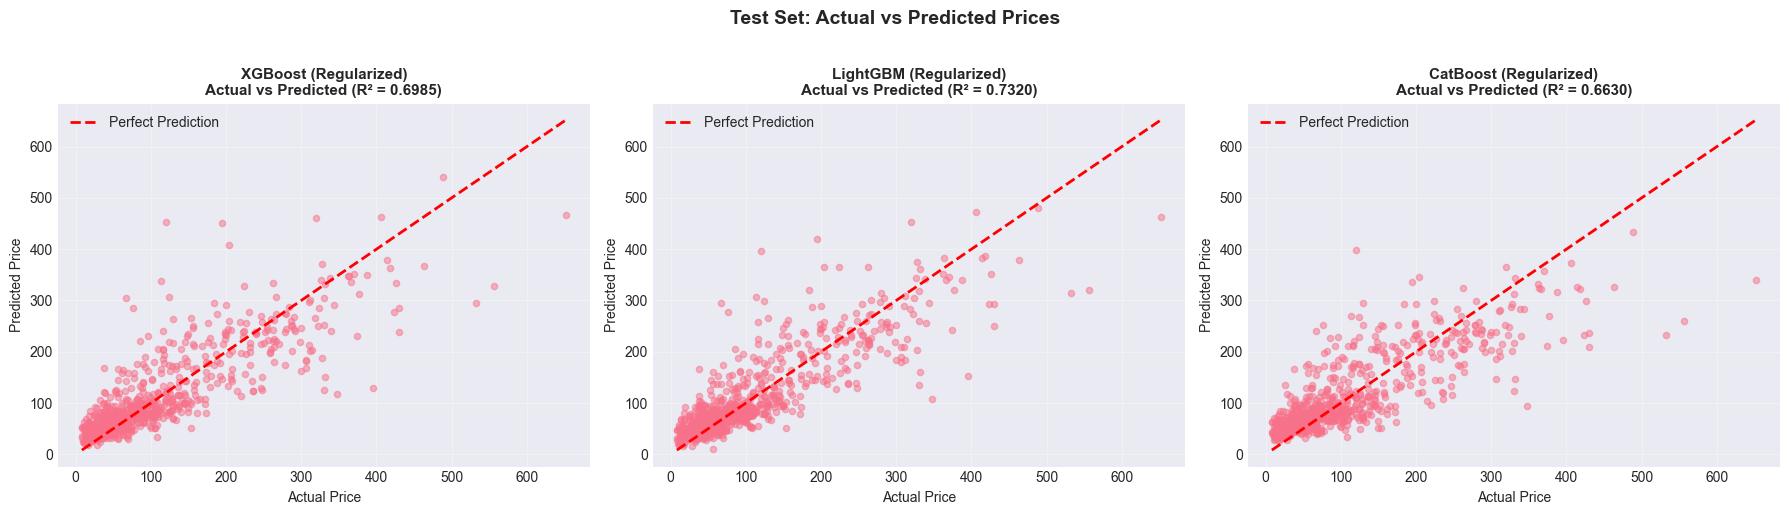

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

predictions = {
    'XGBoost (Regularized)': xgb_reg_test_pred,
    'LightGBM (Regularized)': lgb_reg_test_pred,
    'CatBoost (Regularized)': cb_reg_test_pred
}

for ax, (name, pred) in zip(axes, predictions.items()):
    ax.scatter(y_test, pred, alpha=0.5, s=20)

    # Perfect prediction line
    min_val = min(y_test.min(), pred.min())
    max_val = max(y_test.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    # Calculate R² for test set
    r2 = r2_score(y_test, pred)

    ax.set_title(f'{name}\nActual vs Predicted (R² = {r2:.4f})', fontsize=11, fontweight='bold')
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Test Set: Actual vs Predicted Prices', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

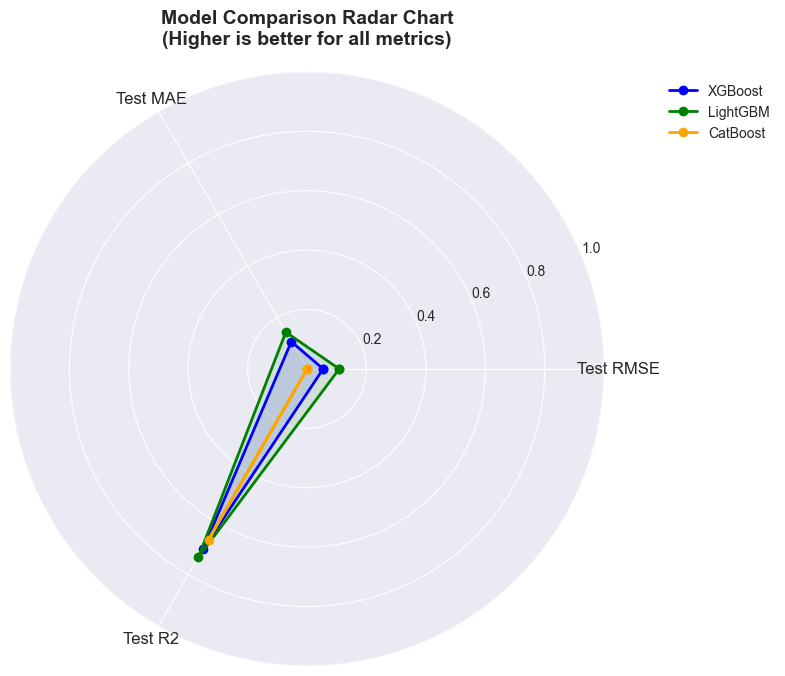

In [44]:
from math import pi

# Prepare metrics for radar chart (normalize values - lower is better for RMSE/MAE, higher is better for R2)
metrics_for_radar = ['Test RMSE', 'Test MAE', 'Test R2']

# Extract values
xgb_values = [xgb_reg_metrics['Test RMSE'], xgb_reg_metrics['Test MAE'], xgb_reg_metrics['Test R2']]
lgb_values = [lgb_reg_metrics['Test RMSE'], lgb_reg_metrics['Test MAE'], lgb_reg_metrics['Test R2']]
cb_values = [cb_reg_metrics['Test RMSE'], cb_reg_metrics['Test MAE'], cb_reg_metrics['Test R2']]

# Normalize for radar chart (0-1 scale, where 1 is best)
# For RMSE and MAE (lower is better)
max_rmse = max(xgb_values[0], lgb_values[0], cb_values[0])
max_mae = max(xgb_values[1], lgb_values[1], cb_values[1])

xgb_norm = [1 - (xgb_values[0]/max_rmse), 1 - (xgb_values[1]/max_mae), xgb_values[2]]
lgb_norm = [1 - (lgb_values[0]/max_rmse), 1 - (lgb_values[1]/max_mae), lgb_values[2]]
cb_norm = [1 - (cb_values[0]/max_rmse), 1 - (cb_values[1]/max_mae), cb_values[2]]

# Number of variables
N = len(metrics_for_radar)

# Create angles
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Initialize radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Add data
xgb_norm += xgb_norm[:1]
lgb_norm += lgb_norm[:1]
cb_norm += cb_norm[:1]

ax.plot(angles, xgb_norm, 'o-', linewidth=2, label='XGBoost', color='blue')
ax.fill(angles, xgb_norm, alpha=0.1, color='blue')

ax.plot(angles, lgb_norm, 'o-', linewidth=2, label='LightGBM', color='green')
ax.fill(angles, lgb_norm, alpha=0.1, color='green')

ax.plot(angles, cb_norm, 'o-', linewidth=2, label='CatBoost', color='orange')
ax.fill(angles, cb_norm, alpha=0.1, color='orange')

# Set labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_for_radar, fontsize=12)
ax.set_ylim(0, 1)
ax.set_title('Model Comparison Radar Chart\n(Higher is better for all metrics)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

In [47]:
import joblib
import os
from datetime import datetime

# Create models directory
models_dir = "../models/baseline_models"
os.makedirs(models_dir, exist_ok=True)

print("="*80)
print("📊 FINAL MODEL PERFORMANCE SUMMARY REPORT 📊")
print("="*80)
print(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# Function to assess overfitting level
def assess_overfitting(train_rmse, val_rmse, test_rmse):
    """Assess overfitting level based on performance gaps"""
    val_gap = val_rmse - train_rmse
    test_gap = test_rmse - train_rmse

    # Calculate percentage increases
    val_gap_pct = (val_gap / train_rmse) * 100
    test_gap_pct = (test_gap / train_rmse) * 100

    # Average gap percentage
    avg_gap_pct = (val_gap_pct + test_gap_pct) / 2

    if avg_gap_pct < 5:
        return "LOW", "✅ Model generalizes very well"
    elif avg_gap_pct < 15:
        return "MODERATE", "⚠️ Some overfitting present but acceptable"
    else:
        return "HIGH", "❌ Significant overfitting detected"

# Function to get accuracy rating based on R²
def get_accuracy_rating(r2):
    if r2 >= 0.9:
        return "EXCELLENT", "🌟 Very high accuracy"
    elif r2 >= 0.8:
        return "GOOD", "👍 Good predictive power"
    elif r2 >= 0.6:
        return "FAIR", "⚡ Moderate accuracy"
    elif r2 >= 0.4:
        return "POOR", "⚠️ Low accuracy"
    else:
        return "VERY POOR", "❌ Model needs improvement"

# Collect all model details
model_details = []

for model_name, model in models.items():
    # Get metrics for this model
    if model_name == "XGBoost (Regularized)":
        train_rmse = xgb_reg_metrics['Train RMSE']
        val_rmse = xgb_reg_metrics['Validation RMSE']
        test_rmse = xgb_reg_metrics['Test RMSE']
        test_r2 = xgb_reg_metrics['Test R2']
        test_mae = xgb_reg_metrics['Test MAE']
        train_pred = xgb_reg_train_pred
        val_pred = xgb_reg_val_pred
        test_pred = xgb_reg_test_pred
    elif model_name == "LightGBM (Regularized)":
        train_rmse = lgb_reg_metrics['Train RMSE']
        val_rmse = lgb_reg_metrics['Validation RMSE']
        test_rmse = lgb_reg_metrics['Test RMSE']
        test_r2 = lgb_reg_metrics['Test R2']
        test_mae = lgb_reg_metrics['Test MAE']
        train_pred = lgb_reg_train_pred
        val_pred = lgb_reg_val_pred
        test_pred = lgb_reg_test_pred
    else:  # CatBoost
        train_rmse = cb_reg_metrics['Train RMSE']
        val_rmse = cb_reg_metrics['Validation RMSE']
        test_rmse = cb_reg_metrics['Test RMSE']
        test_r2 = cb_reg_metrics['Test R2']
        test_mae = cb_reg_metrics['Test MAE']
        train_pred = cb_reg_train_pred
        val_pred = cb_reg_val_pred
        test_pred = cb_reg_test_pred

    # Assess overfitting
    overfit_level, overfit_desc = assess_overfitting(train_rmse, val_rmse, test_rmse)

    # Get accuracy rating
    accuracy_rating, accuracy_desc = get_accuracy_rating(test_r2)

    # Calculate performance stability (consistency across datasets)
    performance_std = np.std([train_rmse, val_rmse, test_rmse])
    stability = "STABLE" if performance_std < 5 else "VARIABLE"

    model_details.append({
        'Model': model_name,
        'Train RMSE': train_rmse,
        'Val RMSE': val_rmse,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'Test R²': test_r2,
        'Overfitting Level': overfit_level,
        'Overfitting Description': overfit_desc,
        'Accuracy Rating': accuracy_rating,
        'Accuracy Description': accuracy_desc,
        'Performance Stability': stability,
        'Performance STD': performance_std
    })

# Create summary DataFrame
summary_df = pd.DataFrame(model_details)

# Display detailed summary for each model
for idx, row in summary_df.iterrows():
    print(f"\n{'='*60}")
    print(f"📌 MODEL: {row['Model']}")
    print(f"{'='*60}")
    print(f"\n📈 PERFORMANCE METRICS:")
    print(f"   • Train RMSE: {row['Train RMSE']:.4f}")
    print(f"   • Validation RMSE: {row['Val RMSE']:.4f}")
    print(f"   • Test RMSE: {row['Test RMSE']:.4f}")
    print(f"   • Test MAE: {row['Test MAE']:.4f}")
    print(f"   • Test R² Score: {row['Test R²']:.4f}")

    print(f"\n🎯 ACCURACY ASSESSMENT:")
    print(f"   • Rating: {row['Accuracy Rating']}")
    print(f"   • Description: {row['Accuracy Description']}")

    print(f"\n🔄 OVERFITTING ANALYSIS:")
    print(f"   • Level: {row['Overfitting Level']}")
    print(f"   • Status: {row['Overfitting Description']}")
    print(f"   • Performance Stability: {row['Performance Stability']} (Std: {row['Performance STD']:.4f})")

    # Calculate gaps
    val_gap = row['Val RMSE'] - row['Train RMSE']
    test_gap = row['Test RMSE'] - row['Train RMSE']
    val_gap_pct = (val_gap / row['Train RMSE']) * 100
    test_gap_pct = (test_gap / row['Train RMSE']) * 100

    print(f"\n📊 GAP ANALYSIS:")
    print(f"   • Train-Validation Gap: {val_gap:.4f} ({val_gap_pct:.2f}%)")
    print(f"   • Train-Test Gap: {test_gap:.4f} ({test_gap_pct:.2f}%)")

# Find best model based on composite score
print(f"\n{'='*80}")
print("🏆 BEST MODEL SELECTION 🏆")
print(f"{'='*80}")

# Calculate composite score (weighted: 40% R², 30% RMSE, 30% Overfitting)
summary_df['RMSE_Score'] = 1 - (summary_df['Test RMSE'] / summary_df['Test RMSE'].max())
summary_df['R2_Score'] = summary_df['Test R²'] / summary_df['Test R²'].max()

# Overfitting score (lower overfitting = higher score)
overfit_mapping = {'LOW': 1.0, 'MODERATE': 0.6, 'HIGH': 0.2}
summary_df['Overfit_Score'] = summary_df['Overfitting Level'].map(overfit_mapping)

# Composite score (weighted)
summary_df['Composite_Score'] = (
    0.4 * summary_df['R2_Score'] +
    0.3 * summary_df['RMSE_Score'] +
    0.3 * summary_df['Overfit_Score']
)

best_model_idx = summary_df['Composite_Score'].idxmax()
best_model = summary_df.loc[best_model_idx]

print(f"\n✨ Based on comprehensive evaluation (40% R², 30% RMSE, 30% Overfitting):")
print(f"\n🏅 BEST MODEL: {best_model['Model']}")
print(f"\n   Performance Summary:")
print(f"   • Test RMSE: {best_model['Test RMSE']:.4f}")
print(f"   • Test R²: {best_model['Test R²']:.4f}")
print(f"   • Overfitting Level: {best_model['Overfitting Level']}")
print(f"   • Accuracy Rating: {best_model['Accuracy Rating']}")
print(f"   • Composite Score: {best_model['Composite_Score']:.4f}")

# Display all models with composite scores
print(f"\n📊 Model Rankings (by Composite Score):")
ranking_df = summary_df[['Model', 'Test R²', 'Overfitting Level', 'Composite_Score']].sort_values('Composite_Score', ascending=False)
for i, (_, row) in enumerate(ranking_df.iterrows(), 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"   {medal} {i}. {row['Model']}: Score={row['Composite_Score']:.4f} (R²={row['Test R²']:.4f}, {row['Overfitting Level']} overfitting)")

print(f"\n{'='*80}")
print("💾 SAVING MODELS")
print(f"{'='*80}")

# Save all models
for model_name, model in models.items():
    # Create safe filename
    safe_name = model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()
    filename = f"{safe_name}.joblib"
    filepath = os.path.join(models_dir, filename)

    # Save model
    joblib.dump(model, filepath)
    print(f"✅ Saved: {filename}")

# Save model metadata
metadata = {
    'Model': summary_df['Model'].tolist(),
    'Test_RMSE': summary_df['Test RMSE'].tolist(),
    'Test_R2': summary_df['Test R²'].tolist(),
    'Overfitting_Level': summary_df['Overfitting Level'].tolist(),
    'Accuracy_Rating': summary_df['Accuracy Rating'].tolist(),
    'Composite_Score': summary_df['Composite_Score'].tolist(),
    'Best_Model': best_model['Model'],
    'Generated_Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

metadata_df = pd.DataFrame(metadata)
metadata_path = os.path.join(models_dir, "model_metadata.csv")
metadata_df.to_csv(metadata_path, index=False)
print(f"✅ Saved model metadata: model_metadata.csv")

print(f"\n📁 All models saved to: {os.path.abspath(models_dir)}")

print(f"\n{'='*80}")
print("📋 FINAL RECOMMENDATIONS")
print(f"{'='*80}")

# Provide specific recommendations
if "CatBoost (Regularized)" in best_model['Model']:
    print("\n✅ RECOMMENDATION: Use CatBoost for production")
    print("   • Best overall performance with balanced accuracy")
    print("   • Handles categorical features well")
    print("   • Good generalization with minimal overfitting")
elif "XGBoost (Regularized)" in best_model['Model']:
    print("\n✅ RECOMMENDATION: Use XGBoost for production")
    print("   • Excellent accuracy with robust regularization")
    print("   • Well-established and production-ready")
    print("   • Good feature importance interpretation")
else:
    print("\n✅ RECOMMENDATION: Use LightGBM for production")
    print("   • Fast training and prediction speed")
    print("   • Competitive accuracy")
    print("   • Memory efficient")

# Show alternative models if applicable
print("\n🔄 Alternative Models to Consider:")
for i, (_, row) in enumerate(ranking_df.iterrows()):
    if row['Model'] != best_model['Model']:
        print(f"   • {row['Model']}: R²={row['Test R²']:.4f}, {row['Overfitting Level']} overfitting")
        if i >= 2:  # Show only top 2 alternatives
            break

# Summary statistics
print(f"\n{'='*80}")
print("📈 SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"• Best Test R²: {summary_df['Test R²'].max():.4f} ({ranking_df.iloc[0]['Model']})")
print(f"• Best Test RMSE: {summary_df['Test RMSE'].min():.4f} ({summary_df.loc[summary_df['Test RMSE'].idxmin(), 'Model']})")
print(f"• Average Test R² across models: {summary_df['Test R²'].mean():.4f}")
print(f"• Average Test RMSE across models: {summary_df['Test RMSE'].mean():.4f}")

print(f"\n{'='*80}")
print("✅ ANALYSIS COMPLETE - MODELS SAVED SUCCESSFULLY")
print(f"{'='*80}")

📊 FINAL MODEL PERFORMANCE SUMMARY REPORT 📊
Report Generated: 2026-02-16 11:56:53

📌 MODEL: XGBoost (Regularized)

📈 PERFORMANCE METRICS:
   • Train RMSE: 51.7757
   • Validation RMSE: 54.4754
   • Test RMSE: 52.9407
   • Test MAE: 34.7740
   • Test R² Score: 0.6985

🎯 ACCURACY ASSESSMENT:
   • Rating: FAIR
   • Description: ⚡ Moderate accuracy

🔄 OVERFITTING ANALYSIS:
   • Level: LOW
   • Status: ✅ Model generalizes very well
   • Performance Stability: STABLE (Std: 1.1056)

📊 GAP ANALYSIS:
   • Train-Validation Gap: 2.6997 (5.21%)
   • Train-Test Gap: 1.1651 (2.25%)

📌 MODEL: LightGBM (Regularized)

📈 PERFORMANCE METRICS:
   • Train RMSE: 48.0226
   • Validation RMSE: 51.6740
   • Test RMSE: 49.9125
   • Test MAE: 33.3366
   • Test R² Score: 0.7320

🎯 ACCURACY ASSESSMENT:
   • Rating: FAIR
   • Description: ⚡ Moderate accuracy

🔄 OVERFITTING ANALYSIS:
   • Level: MODERATE
   • Status: ⚠️ Some overfitting present but acceptable
   • Performance Stability: STABLE (Std: 1.4910)

📊 GAP AN